In [33]:
import os
# 模型相关参数
num_labels = 3
TEST_DATASET_SIZE = 0.4
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}
MODEL_NAME = f'distilbert-base-uncased'
DATA_PATH = f'./data/citation_sentiment_corpus.csv'
DATA_PATH_NEW = f'./data/citation_sentiment_corpus_new.csv'
SST2_FINETUNED_MODEL_PATH = f'./model/distilbert-base-uncased-finetuned-sst-2-english'
BASE_MODEL_PATH = f'./model/distilbert-base-uncased'


# 训练相关参数
USE_DATALOADER = False
USE_BASE_MODEL = False
batch_size = 32
loss_type='ce_loss' # 自定义参数 focal_loss dsc_loss ce_loss
weight_decay = 0.01
lr = 5e-6
num_epochs = 5
warmup_steps = 100
label_smoothing_factor = 0.0


In [34]:
import pandas as pd
import torch


rawdata_df = pd.read_csv(DATA_PATH)
rawdata_df['Sentiment'] = rawdata_df['Sentiment'].map({'o': 0, 'p': 1, 'n': 2})
rawdata_df['Sentence_Length'] = rawdata_df['Citation_Text'].str.len()
rawdata_df = rawdata_df[rawdata_df['Sentence_Length'] <= 1024]
print(rawdata_df.shape)
rawdata_df.to_csv(DATA_PATH_NEW, index=False)
rawdata_df = pd.read_csv(DATA_PATH_NEW)

(8699, 5)


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [36]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from datasets import Dataset, DatasetDict

# 分割数据集：训练集80%，验证集10%，测试集10%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    rawdata_df['Citation_Text'].tolist(), rawdata_df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=rawdata_df['Sentiment'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

class MyDataset(Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        super(MyDataset, self).__init__()
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# 将数据转换为 HuggingFace 的 Dataset 格式
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_dataset = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': test_dataset})

tokenized_datasets = emotion_dataset.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, max_length=512),
                                  batch_size=None, batched=True) # WordPiece分词器
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])
train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['val']
test_dataset = tokenized_datasets['test']


print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

D:\User\anaconda3\envs\pytorch\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [37]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出结果目录
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir='./logs',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    metric_for_best_model='F1',
    # load_best_model_at_end=True,
    label_smoothing_factor=label_smoothing_factor
)

In [38]:
# 使用Focal loss作为损失函数解决样本不均衡问题
def py_sigmoid_focal_loss(pred, target, gamma=2.0, alpha=0.9, reduction='mean'):
    pred_sigmoid = pred.sigmoid()
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).type_as(pred)  # 转换为one-hot编码
    pt = (1 - pred_sigmoid) * target + pred_sigmoid * (1 - target)
    focal_weight = (alpha * target + (1 - alpha) * (1 - target)) * pt.pow(gamma)
    loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none') * focal_weight
    return loss.mean() if reduction == 'mean' else loss.sum()

class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyper-parameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss

In [39]:
# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

In [40]:
import torch
import torch.nn.functional as F

 
class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [41]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# 创建Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type # 自定义参数 focal_loss dsc_loss
)

results = trainer.train() 

RuntimeError: grad can be implicitly created only for scalar outputs

  0%|          | 0/38 [00:00<?, ?it/s]

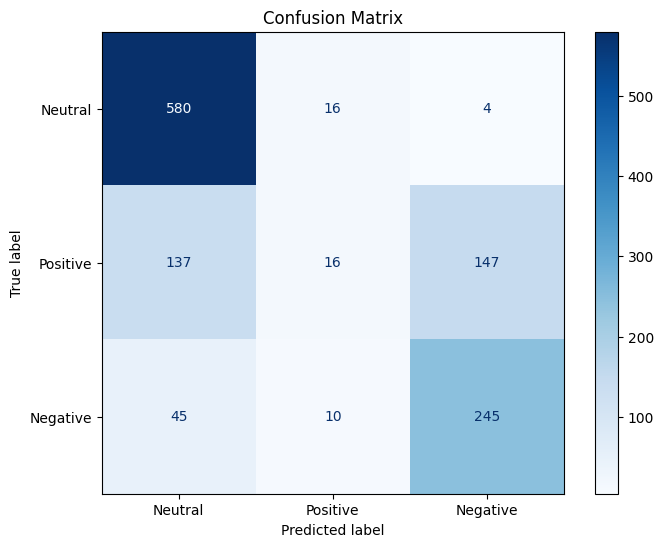

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()


preds_output = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(preds_output.predictions), dim=-1).numpy()
predicted_labels = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))
    
    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
tokenized_datasets["val"] = tokenized_datasets["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_datasets["val"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
239,polarity turney verb measures noun consider cl...,Negative,Neutral,3.081703
674,bootstrapping em structure yarowsky each eithe...,Negative,Neutral,3.045681
502,tillmann reference liang instead directly zhan...,Negative,Neutral,3.019126
6,account ibm phrase alignment under standard do...,Negative,Neutral,3.012346
822,cannot tag tagging ratnaparkhi tagger word 199...,Negative,Neutral,3.010471
101,uses note similar 2007 method to our which tha...,Negative,Neutral,2.974247
933,bootstrapping yarowsky disambiguation sense pa...,Negative,Neutral,2.959000
873,averaged perceptron estimated collins training...,Negative,Neutral,2.952198
3,mt shen dependency provides over models langua...,Negative,Neutral,2.919110
601,wiebe labeled yarowsky small resnik supervised...,Negative,Neutral,2.893411


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
732,ramshaw marcus scheme annotated tagging 1995 i...,Neutral,Neutral,0.171856
368,sources evaluate implementation collins parse ...,Neutral,Neutral,0.179551
706,ramshaw marcus labeling entity labeled where c...,Neutral,Neutral,0.179588
584,patterns form collins parsed then verb these t...,Neutral,Neutral,0.183005
292,hoang mapping value koehn target side sequence...,Neutral,Neutral,0.183141
870,marcus sections treebank penn grammars learn 1...,Neutral,Neutral,0.184061
571,12 provided yarowsky each list words 1995 show...,Neutral,Neutral,0.184273
1028,agreement carletta inter annotations follow an...,Neutral,Neutral,0.184496
657,dunning ratio pair log pairs compute associati...,Neutral,Neutral,0.184609
273,melamed strings parsing grammars inference fre...,Neutral,Neutral,0.184730


In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

best_model_dir = './model/distilbert-base-uncased-finetuned-citation'
trainer.save_model(best_model_dir)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)


# def predict_sentiment_score(model, dataset, batched=True, batch_size=32, weights=[-0.5, 1, -1], shuffle=False):
#     '''
#     预测句子的情感
#     '''
#     results = []
#     sentiment_scores = []
#     model.eval()  # 将模型设置为评估模式

#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

#     if batched:
#         with torch.no_grad():  # 不计算梯度，以加速和节省内存
#             for batch in dataloader:
#                 # 将批次数据移动到cuda
#                 batch = {k: v.to(device) for k, v in batch.items()}
#                 outputs = model(**batch)
#                 logits = outputs.logits
#                 probabilities = F.softmax(logits, dim=-1)
                
#                 logits_list = logits.tolist()
#                 probabilities_list = probabilities.tolist()
#                 results.extend(zip(logits_list, probabilities_list))
#     else:
#         with torch.no_grad():
#             inputs = tokenizer(dataset, return_tensors='pt', truncation=True, padding=True).to(device)
#             outputs = model(**inputs)
#             logits = outputs.logits
#             probabilities = F.softmax(logits, dim=-1)
#             logits_list = logits.tolist()
#             probabilities_list = probabilities.tolist()
#             results.extend(zip(logits_list, probabilities_list))

#     for _, softmax_probs in results:
#         softmax_probs_array = np.array(softmax_probs)
#         weights_array = np.array(weights)
#         score = np.sum(softmax_probs_array * weights_array)
#         score = max(min(score, 1), -1)
#         sentiment_scores.append(score)
#     return sentiment_scores

# weights=[-0.1, 1, -1]
# all_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
# sentiment_scores = predict_sentiment_score(best_model, all_dataset, weights=weights, batched=True, batch_size=1, shuffle=True) # 句子维度不一样就把batch_size设为1
